# Assignment 3.
### Тема: Архитектура GPU и оптимизация CUDA-программ
Задание 1 (25 баллов)
Реализуйте программу на CUDA для поэлементной обработки массива (например,
умножение каждого элемента на число). Реализуйте две версии программы:
1. с использованием только глобальной памяти;
2. с использованием разделяемой памяти.
Сравните время выполнения обеих реализаций для массива размером 1 000 000
элементов.

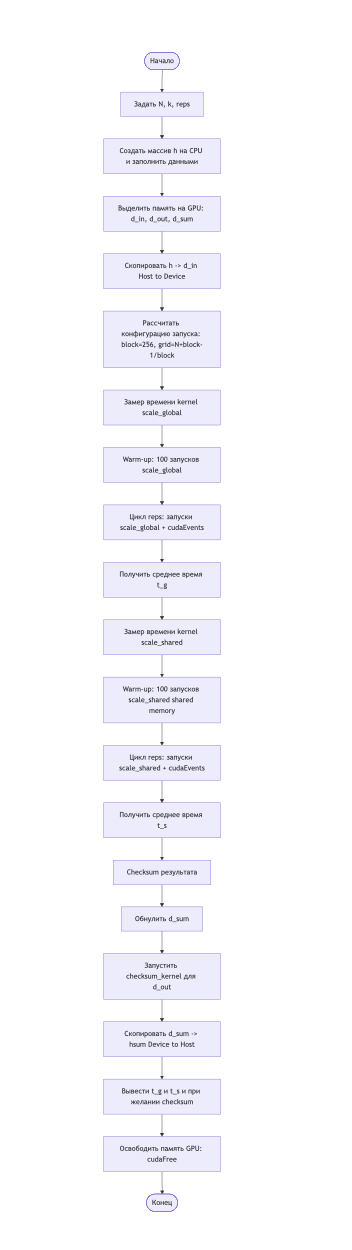

In [ ]:
!nvidia-smi


Mon Jan 12 10:13:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%%writefile task1_scale.cu
#include <cstdio>              // printf
#include <vector>              // std::vector для массива на CPU
#include <cuda_runtime.h>      // всё для CUDA (cudaMalloc, cudaMemcpy, events и т.д.)

// Макрос для проверки ошибок CUDA, чтобы не ловить “тихие” ошибки
#define CHECK(call) do{ cudaError_t e=(call); if(e!=cudaSuccess){ \
  printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); exit(1);} }while(0)

// ---------- Kernel 1: версия только с глобальной памятью ----------
__global__ void scale_global(const float* __restrict__ in,  // входной массив в global memory
                             float* __restrict__ out,       // выходной массив в global memory
                             float k,                       // коэффициент умножения
                             int n){                        // размер массива
  int i = blockIdx.x * blockDim.x + threadIdx.x;            // глобальный индекс элемента
  if(i < n) out[i] = in[i] * k;                             // поэлементное умножение
}

// ---------- Kernel 2: версия с shared memory ----------
__global__ void scale_shared(const float* __restrict__ in,  // вход (global)
                             float* __restrict__ out,       // выход (global)
                             float k, int n){
  extern __shared__ float sh[];                             // динамическая shared память (на блок)
  int tid = threadIdx.x;                                    // индекс потока внутри блока
  int i = blockIdx.x * blockDim.x + tid;                    // глобальный индекс элемента

  if(i < n) sh[tid] = in[i];                                // сначала грузим из global в shared
  __syncthreads();                                          // ждём, пока все потоки блока загрузят данные

  if(i < n) out[i] = sh[tid] * k;                           // потом считаем из shared и пишем обратно в global
}

// ---------- Kernel 3: checksum, чтобы результат реально использовался ----------
__global__ void checksum_kernel(const float* __restrict__ in, // массив, по которому считаем сумму
                                float* out_sum,              // одна переменная в global (куда складываем)
                                int n){
  __shared__ float s[256];                                   // shared массив для редукции внутри блока (256 потоков)
  int tid = threadIdx.x;                                     // локальный id потока
  int i = blockIdx.x * blockDim.x + tid;                     // глобальный индекс

  float x = (i < n) ? in[i] : 0.0f;                          // если вышли за границу — берём 0
  s[tid] = x;                                                // кладём значение в shared
  __syncthreads();                                           // синхронизация перед редукцией

  // редукция суммы внутри блока (сворачиваем s[] до одного значения)
  for(int offset = blockDim.x/2; offset > 0; offset >>= 1){  // offset делим на 2 каждый шаг
    if(tid < offset) s[tid] += s[tid + offset];              // складываем пары элементов
    __syncthreads();                                         // синхронизация на каждом шаге
  }

  if(tid == 0) atomicAdd(out_sum, s[0]);                     // один поток блока добавляет результат в общую сумму
}

// ---------- Замер времени: global версия (много запусков) ----------
float time_many_launches_global(int grid, int block,          // конфигурация запуска
                                const float* d_in,            // вход на GPU
                                float* d_out,                 // выход на GPU
                                float k, int n,               // параметры вычисления
                                int reps){                    // сколько раз запускать kernel
  cudaEvent_t st, en;                                         // CUDA events для времени
  CHECK(cudaEventCreate(&st));                                // создаём start event
  CHECK(cudaEventCreate(&en));                                // создаём end event

  // warm-up: прогрев GPU, чтобы первый запуск не искажал измерение
  for(int i=0;i<100;i++) scale_global<<<grid,block>>>(d_in,d_out,k,n); // 100 быстрых запусков
  CHECK(cudaGetLastError());                                  // проверяем, что kernel запустился без ошибок
  CHECK(cudaDeviceSynchronize());                             // ждём завершения прогрева

  CHECK(cudaEventRecord(st));                                 // старт таймера
  for(int i=0;i<reps;i++) scale_global<<<grid,block>>>(d_in,d_out,k,n); // основной цикл запусков
  CHECK(cudaEventRecord(en));                                 // стоп таймера
  CHECK(cudaEventSynchronize(en));                            // ждём, пока end event реально наступит
  CHECK(cudaGetLastError());                                  // ещё раз проверка ошибок kernel

  float ms = 0;                                               // сюда запишем миллисекунды
  CHECK(cudaEventElapsedTime(&ms, st, en));                    // считаем время между событиями
  CHECK(cudaEventDestroy(st));                                 // удаляем события
  CHECK(cudaEventDestroy(en));                                 // удаляем события
  return ms / reps;                                           // возвращаем среднее время одного запуска
}

// ---------- Замер времени: shared версия (много запусков) ----------
float time_many_launches_shared(int grid, int block,
                                const float* d_in,
                                float* d_out,
                                float k, int n,
                                int reps){
  cudaEvent_t st, en;                                         // события для времени
  CHECK(cudaEventCreate(&st));                                // start event
  CHECK(cudaEventCreate(&en));                                // end event

  // warm-up для shared версии
  for(int i=0;i<100;i++) scale_shared<<<grid,block, block*sizeof(float)>>>(d_in,d_out,k,n); // shared = block floats
  CHECK(cudaGetLastError());                                  // проверка ошибки запуска
  CHECK(cudaDeviceSynchronize());                             // ждём завершения warm-up

  CHECK(cudaEventRecord(st));                                 // старт измерения
  for(int i=0;i<reps;i++) scale_shared<<<grid,block, block*sizeof(float)>>>(d_in,d_out,k,n); // основной цикл
  CHECK(cudaEventRecord(en));                                 // стоп измерения
  CHECK(cudaEventSynchronize(en));                            // ждём завершения
  CHECK(cudaGetLastError());                                  // проверка ошибок

  float ms = 0;                                               // результат в мс
  CHECK(cudaEventElapsedTime(&ms, st, en));                    // вычисляем время
  CHECK(cudaEventDestroy(st));                                 // чистим ресурсы
  CHECK(cudaEventDestroy(en));                                 // чистим ресурсы
  return ms / reps;                                           // среднее время на запуск
}

int main(){
  const int N = 1'000'000;                                    // размер массива
  const size_t bytes = (size_t)N * sizeof(float);             // сколько байт надо под массив float
  const float k = 2.5f;                                       // коэффициент умножения

  std::vector<float> h(N);                                    // массив на CPU
  for(int i=0;i<N;i++) h[i] = (i%100)*0.01f;                  // простая инициализация данных

  float *d_in=nullptr, *d_out=nullptr, *d_sum=nullptr;        // указатели на GPU
  CHECK(cudaMalloc(&d_in, bytes));                            // выделяем память под вход
  CHECK(cudaMalloc(&d_out, bytes));                           // выделяем память под выход
  CHECK(cudaMalloc(&d_sum, sizeof(float)));                   // выделяем память под checksum (одно число)

  CHECK(cudaMemcpy(d_in, h.data(), bytes, cudaMemcpyHostToDevice)); // копируем вход с CPU на GPU

  int block = 256;                                            // размер блока (256 потоков)
  int grid  = (N + block - 1)/block;                          // сколько блоков нужно, чтобы покрыть N

  const int reps = 5000;                                      // число запусков (чтобы время было стабильным)

  float t_g = time_many_launches_global(grid, block, d_in, d_out, k, N, reps); // avg для global
  float t_s = time_many_launches_shared(grid, block, d_in, d_out, k, N, reps); // avg для shared

  // checksum после последнего запуска — чтобы компилятор/драйвер не “игнорировали” результат
  CHECK(cudaMemset(d_sum, 0, sizeof(float)));                 // обнуляем сумму на GPU
  int grid_sum = (N + 256 - 1)/256;                            // сетка для checksum (тоже 256 потоков)
  checksum_kernel<<<grid_sum,256>>>(d_out, d_sum, N);          // запускаем редукцию суммы
  CHECK(cudaGetLastError());                                  // проверяем ошибки kernel
  CHECK(cudaDeviceSynchronize());                             // ждём завершения checksum

  float hsum = 0;                                             // checksum на CPU
  CHECK(cudaMemcpy(&hsum, d_sum, sizeof(float), cudaMemcpyDeviceToHost)); // копируем checksum на CPU

  printf("Task 1 (N=%d, block=%d, reps=%d)\n", N, block, reps); // печатаем параметры
  printf("  global-only : avg=%.6f ms\n", t_g);                // печатаем время global версии
  printf("  shared-mem  : avg=%.6f ms\n", t_s);                // печатаем время shared версии
  // printf("  checksum(out)=%.4f\n", hsum);                   // можно печатать checksum (не обязательно)

  CHECK(cudaFree(d_in));                                      // освобождаем память GPU (вход)
  CHECK(cudaFree(d_out));                                     // освобождаем память GPU (выход)
  CHECK(cudaFree(d_sum));                                     // освобождаем память GPU (checksum)
  return 0;                                                   // конец программы
}

Overwriting task1_scale.cu


In [ ]:
!nvcc -O3 -arch=sm_75 task1_scale.cu -o task1
!./task1

Task 1 (N=1000000, block=256, reps=5000)
  global-only : avg=0.037910 ms
  shared-mem  : avg=0.033998 ms


Вывод: использование shared памяти может немного ускорить обработку, но для простой операции (масштабирование массива) выигрыш небольшой, потому что данные используются один раз и основное время — доступ к памяти.

Задание 2 (25 баллов)
Реализуйте CUDA-программу для поэлементного сложения двух массивов. Исследуйте
влияние размера блока потоков на производительность программы. Проведите замеры времени для как минимум трёх различных размеров блока.

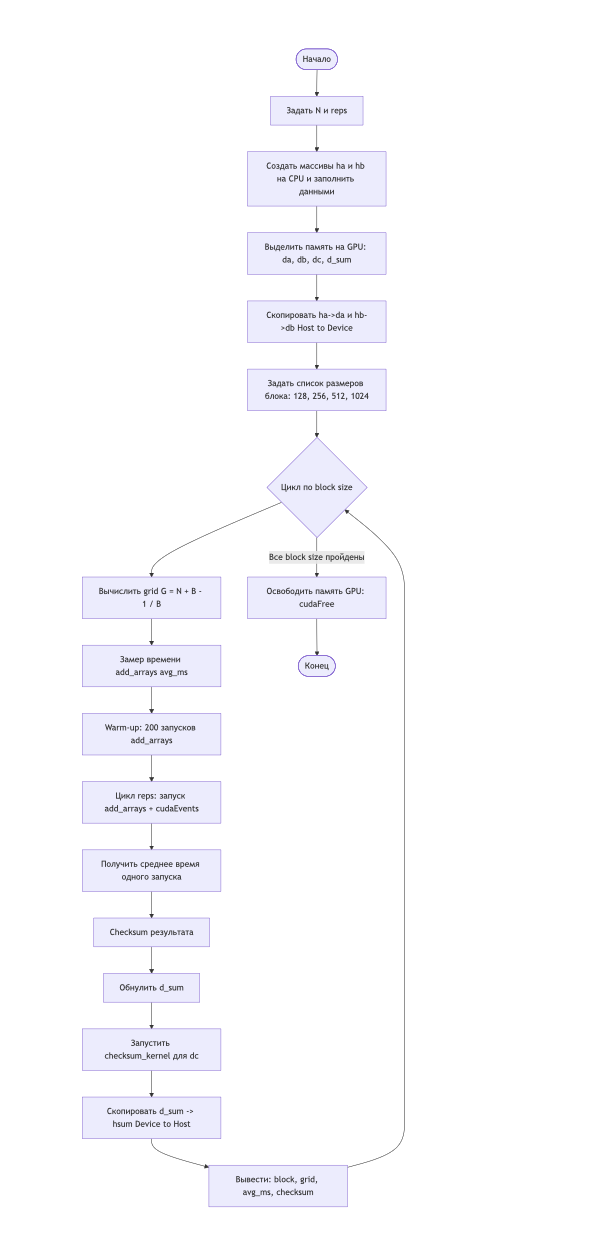

In [ ]:
%%writefile task2_add_blocksize.cu
#include <cstdio>              // printf
#include <vector>              // std::vector для массивов на CPU
#include <cuda_runtime.h>      // CUDA функции: cudaMalloc, cudaMemcpy, events и т.д.

// Макрос: проверяем ошибки CUDA после каждого важного вызова
#define CHECK(call) do{ cudaError_t e=(call); if(e!=cudaSuccess){ \
  printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); exit(1);} }while(0)

// ----------------------
// CUDA kernel: поэлементное сложение массивов
// c[i] = a[i] + b[i]
__global__ void add_arrays(const float* __restrict__ a,     // массив A в global memory
                           const float* __restrict__ b,     // массив B в global memory
                           float* __restrict__ c,           // массив C (результат)
                           int n){                          // размер массивов
  int i = blockIdx.x * blockDim.x + threadIdx.x;            // глобальный индекс элемента
  if(i < n) c[i] = a[i] + b[i];                             // если i в пределах массива, складываем
}

// ----------------------
// CUDA kernel: checksum (контрольная сумма)
// Считаем сумму элементов массива C, чтобы результат реально использовался
__global__ void checksum_kernel(const float* __restrict__ in, // входной массив
                                float* out_sum,              // куда складываем сумму
                                int n){
  __shared__ float s[256];                                   // shared массив для редукции внутри блока
  int tid = threadIdx.x;                                     // номер потока внутри блока
  int i = blockIdx.x * blockDim.x + tid;                     // глобальный индекс

  float x = (i < n) ? in[i] : 0.0f;                          // если вышли за границу массива — 0
  s[tid] = x;                                                // кладём значение в shared память
  __syncthreads();                                           // синхронизация потоков блока

  // редукция суммы в блоке (сворачиваем s[0..255] в s[0])
  for(int offset = blockDim.x/2; offset > 0; offset >>= 1){
    if(tid < offset) s[tid] += s[tid + offset];              // складываем пары элементов
    __syncthreads();                                         // синхронизация после каждого шага
  }

  // один поток (tid=0) добавляет сумму блока в общий результат
  if(tid == 0) atomicAdd(out_sum, s[0]);                     // atomicAdd нужен, т.к. блоков много
}

// ----------------------
// Функция замера времени: запускаем kernel много раз и считаем среднее время 1 запуска
float time_many_launches(int grid, int block,               // grid и block конфигурация запуска
                         const float* da, const float* db,   // входные массивы на GPU
                         float* dc,                          // выходной массив на GPU
                         int n, int reps){                   // размер массива + число повторов
  cudaEvent_t st, en;                                        // CUDA events для таймера
  CHECK(cudaEventCreate(&st));                               // создаём start event
  CHECK(cudaEventCreate(&en));                               // создаём end event

  // ---- warm-up: прогрев GPU (чтобы первый запуск не искажал время)
  for(int i=0;i<200;i++) add_arrays<<<grid,block>>>(da,db,dc,n);
  CHECK(cudaGetLastError());                                 // проверяем ошибки запуска kernel
  CHECK(cudaDeviceSynchronize());                            // ждём завершения

  // ---- основной замер времени
  CHECK(cudaEventRecord(st));                                // старт измерения
  for(int i=0;i<reps;i++) add_arrays<<<grid,block>>>(da,db,dc,n); // много запусков ядра
  CHECK(cudaEventRecord(en));                                // конец измерения
  CHECK(cudaEventSynchronize(en));                           // ждём завершения
  CHECK(cudaGetLastError());                                 // проверка ошибок

  float ms = 0;                                              // тут будет время в миллисекундах
  CHECK(cudaEventElapsedTime(&ms, st, en));                   // сколько ms прошло между st и en

  CHECK(cudaEventDestroy(st));                               // удаляем события
  CHECK(cudaEventDestroy(en));

  return ms / reps;                                          // среднее время одного запуска
}

int main(){
  const int N = 1'000'000;                                   // размер массива
  const size_t bytes = (size_t)N * sizeof(float);            // количество байт на массив float

  // ---- создаём массивы на CPU
  std::vector<float> ha(N), hb(N);                           // массив A и массив B на CPU
  for(int i=0;i<N;i++){                                      // инициализируем значениями
    ha[i] = (i % 100) * 0.01f;
    hb[i] = (i % 50)  * 0.02f;
  }

  // ---- указатели на память GPU
  float *da=nullptr, *db=nullptr, *dc=nullptr, *d_sum=nullptr;

  // ---- выделяем память на GPU
  CHECK(cudaMalloc(&da, bytes));                             // A на GPU
  CHECK(cudaMalloc(&db, bytes));                             // B на GPU
  CHECK(cudaMalloc(&dc, bytes));                             // C на GPU
  CHECK(cudaMalloc(&d_sum, sizeof(float)));                  // checksum (одно число)

  // ---- копируем массивы A и B на GPU
  CHECK(cudaMemcpy(da, ha.data(), bytes, cudaMemcpyHostToDevice));
  CHECK(cudaMemcpy(db, hb.data(), bytes, cudaMemcpyHostToDevice));

  // ---- разные размеры блока (тут минимум 3, у нас 4)
  int blocks[] = {128, 256, 512, 1024};
  int ntests = 4;

  // reps выбираем так, чтобы общее время было не очень маленькое (иначе округление)
  const int reps = 8000;

  printf("Task 2 (N=%d, reps=%d)\n", N, reps);

  // ---- тестируем разные block sizes
  for(int t=0;t<ntests;t++){
    int B = blocks[t];                                       // block size (сколько потоков в блоке)
    int G = (N + B - 1) / B;                                 // grid size (сколько блоков)

    // замер среднего времени одного запуска
    float avg_ms = time_many_launches(G, B, da, db, dc, N, reps);

    // ---- checksum: чтобы результат точно использовался
    CHECK(cudaMemset(d_sum, 0, sizeof(float)));              // обнуляем сумму на GPU

    int grid_sum = (N + 256 - 1) / 256;                      // сетка для checksum
    checksum_kernel<<<grid_sum,256>>>(dc, d_sum, N);          // запускаем checksum kernel
    CHECK(cudaGetLastError());                               // проверка ошибок
    CHECK(cudaDeviceSynchronize());                          // ждём завершения

    float hsum = 0;                                          // checksum на CPU
    CHECK(cudaMemcpy(&hsum, d_sum, sizeof(float), cudaMemcpyDeviceToHost));

    // вывод результатов для текущего блока
    printf("  block=%4d grid=%6d  avg=%.6f ms  checksum=%.3f\n", B, G, avg_ms, hsum);
  }

  // ---- освобождаем память GPU
  CHECK(cudaFree(da));
  CHECK(cudaFree(db));
  CHECK(cudaFree(dc));
  CHECK(cudaFree(d_sum));

  return 0;                                                  // конец программы
}

Overwriting task2_add_blocksize.cu


In [ ]:
!nvcc -O3 -arch=sm_75 task2_add_blocksize.cu -o task2
!./task2

Task 2 (N=1000000, reps=8000)
  block= 128 grid=  7813  avg=0.048950 ms  checksum=985000.062
  block= 256 grid=  3907  avg=0.048483 ms  checksum=985000.062
  block= 512 grid=  1954  avg=0.048523 ms  checksum=984999.938
  block=1024 grid=   977  avg=0.048627 ms  checksum=985000.000


Вывод: По результатам измерений минимальное среднее время выполнения показал размер блока 256 потоков: 0.048483 ms. Для данной задачи оптимальным оказался block = 256, так как он обеспечивает наиболее удачный баланс производительности и загрузки GPU. Также,чтобы гарантировать, что результат вычислений на GPU действительно используется был использован Checksum.

Задание 3 (25 баллов)
Реализуйте CUDA-программу для обработки массива, демонстрирующую
коалесцированный и некоалесцированный доступ к глобальной памяти. Сравните время выполнения обеих реализаций для массива размером 1 000 000 элементов.

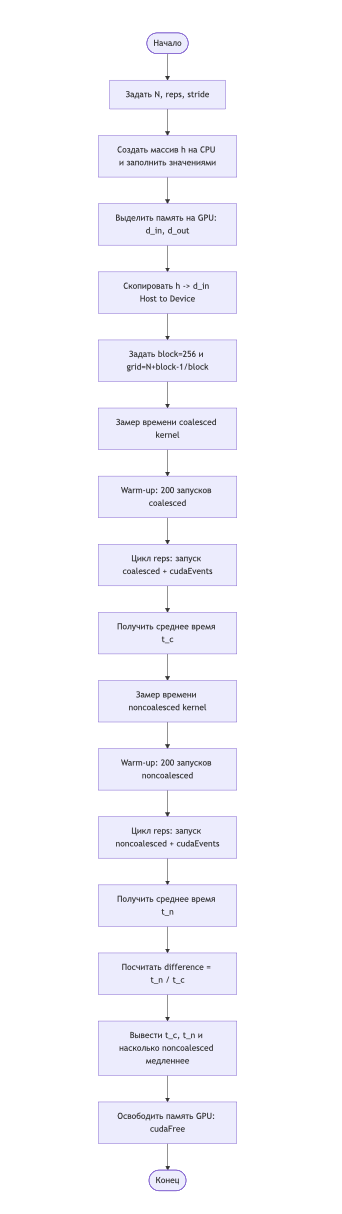

In [ ]:
%%writefile task3_coalesced.cu
#include <cstdio>              // printf
#include <vector>              // std::vector для массивов на CPU
#include <cuda_runtime.h>      // CUDA функции (cudaMalloc, cudaMemcpy, events и т.д.)

// Макрос для проверки ошибок CUDA (чтобы программа не продолжала работу с ошибкой)
#define CHECK(call) do{ cudaError_t e=(call); if(e!=cudaSuccess){ \
  printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); exit(1);} }while(0)

// -----------------------
// Kernel 1: коалесцированный доступ
// Потоки i читают in[i] и пишут out[i] -> обращения идут подряд
__global__ void coalesced(const float* __restrict__ in,    // входной массив в global memory
                          float* __restrict__ out,         // выходной массив в global memory
                          int n){                          // размер массива
  int i = blockIdx.x * blockDim.x + threadIdx.x;           // глобальный индекс элемента
  if(i < n) out[i] = in[i] * 1.000001f;                    // простая операция (чтобы было не просто копирование)
}

// -----------------------
// Kernel 2: некоалесцированный доступ
// Потоки обращаются по "прыгающим" индексам -> транзакций памяти больше
__global__ void noncoalesced(const float* __restrict__ in, // входной массив
                             float* __restrict__ out,      // выходной массив
                             int n,                        // размер массива
                             int stride){                  // шаг доступа, например 32 (ломает coalescing на варпе)
  int i = blockIdx.x * blockDim.x + threadIdx.x;           // глобальный индекс потока
  if(i < n){
    // перестановка индекса: делаем доступ "разреженным", но обрабатываем все N элементов
    int idx = (int)(((long long)i * stride) % n);
    out[idx] = in[idx] * 1.000001f;                        // операция такая же, но адреса памяти хуже для GPU
  }
}

// -----------------------
// Функция замера времени: много запусков (warm-up + reps запусков)
// Возвращает среднее время одного запуска в ms
float time_many_launches_coal(int grid, int block, const float* d_in, float* d_out, int n, int reps){
  cudaEvent_t st, en;                                      // CUDA events для измерения времени
  CHECK(cudaEventCreate(&st));                              // старт
  CHECK(cudaEventCreate(&en));                              // конец

  // warm-up: чтобы “первый запуск” не испортил результаты
  for(int i=0;i<200;i++) coalesced<<<grid,block>>>(d_in,d_out,n);
  CHECK(cudaGetLastError());                                // проверяем ошибки запуска
  CHECK(cudaDeviceSynchronize());                            // ждём завершения

  CHECK(cudaEventRecord(st));                               // старт таймера
  for(int i=0;i<reps;i++) coalesced<<<grid,block>>>(d_in,d_out,n); // основной запуск
  CHECK(cudaEventRecord(en));                               // стоп таймера
  CHECK(cudaEventSynchronize(en));                          // ждём завершения
  CHECK(cudaGetLastError());                                // проверка ошибок

  float ms = 0;                                             // сюда запишется время
  CHECK(cudaEventElapsedTime(&ms, st, en));                 // время между st и en (в ms)

  CHECK(cudaEventDestroy(st));                              // чистим события
  CHECK(cudaEventDestroy(en));
  return ms / reps;                                         // среднее время одного запуска
}

// то же самое, но для noncoalesced kernel
float time_many_launches_non(int grid, int block, const float* d_in, float* d_out, int n, int stride, int reps){
  cudaEvent_t st, en;
  CHECK(cudaEventCreate(&st));
  CHECK(cudaEventCreate(&en));

  // warm-up
  for(int i=0;i<200;i++) noncoalesced<<<grid,block>>>(d_in,d_out,n,stride);
  CHECK(cudaGetLastError());
  CHECK(cudaDeviceSynchronize());

  CHECK(cudaEventRecord(st));
  for(int i=0;i<reps;i++) noncoalesced<<<grid,block>>>(d_in,d_out,n,stride);
  CHECK(cudaEventRecord(en));
  CHECK(cudaEventSynchronize(en));
  CHECK(cudaGetLastError());

  float ms = 0;
  CHECK(cudaEventElapsedTime(&ms, st, en));

  CHECK(cudaEventDestroy(st));
  CHECK(cudaEventDestroy(en));
  return ms / reps;
}

int main(){
  const int N = 1'000'000;                                  // размер массива
  const size_t bytes = (size_t)N * sizeof(float);           // размер в байтах

  // создаём массив на CPU
  std::vector<float> h(N);
  for(int i=0;i<N;i++) h[i] = (i%100)*0.01f;                // заполняем значениями

  // указатели на GPU
  float *d_in=nullptr, *d_out=nullptr;

  // выделяем память на GPU
  CHECK(cudaMalloc(&d_in, bytes));
  CHECK(cudaMalloc(&d_out, bytes));

  // копируем входной массив на GPU
  CHECK(cudaMemcpy(d_in, h.data(), bytes, cudaMemcpyHostToDevice));

  int block = 256;                                          // потоки в блоке
  int grid  = (N + block - 1) / block;                      // количество блоков

  int reps = 8000;                                          // количество запусков для точного времени
  int stride = 32;                                          // stride=32 ломает коалесцирование на уровне варпа

  // замер времени для коалесцированного доступа
  float t_c = time_many_launches_coal(grid, block, d_in, d_out, N, reps);

  // замер времени для некоалесцированного доступа
  float t_n = time_many_launches_non(grid, block, d_in, d_out, N, stride, reps);
  // разница в замерах
  float speedup = t_n / t_c;

  // вывод результатов
  printf("Task 3 (N=%d, block=%d, reps=%d)\n", N, block, reps);
  printf("  coalesced     : %.6f ms\n", t_c);
  printf("  non-coalesced : %.6f ms (stride=%d)\n", t_n, stride);
  printf("  difference    : %.2fx slower (non-coalesced vs coalesced)\n", speedup);

  // освобождаем память GPU
  CHECK(cudaFree(d_in));
  CHECK(cudaFree(d_out));

  return 0;                                                 // конец программы
}

Overwriting task3_coalesced.cu


In [ ]:
!nvcc -O3 -arch=sm_75 task3_coalesced.cu -o task3
!./task3

Task 3 (N=1000000, block=256, reps=8000)
  coalesced     : 0.037132 ms
  non-coalesced : 0.820905 ms (stride=32)
  difference    : 22.11x slower (non-coalesced vs coalesced)


Вывод: Для массива N = 1 000 000 коалесцированный доступ показал 0.037132 ms, а некоалесцированный (stride=32) — 0.820905 ms. Некоалесцированный вариант оказался примерно в 22.11 раза медленнее, потому что потоки обращаются к глобальной памяти “скачками”, и GPU делает больше отдельных транзакций памяти, из-за чего падает пропускная способность.

Задание 4 (25 баллов)
Для одной из реализованных в предыдущих заданиях CUDA-программ подберите
оптимальные параметры конфигурации сетки и блоков потоков. Сравните
производительность неоптимальной и оптимизированной конфигураций.

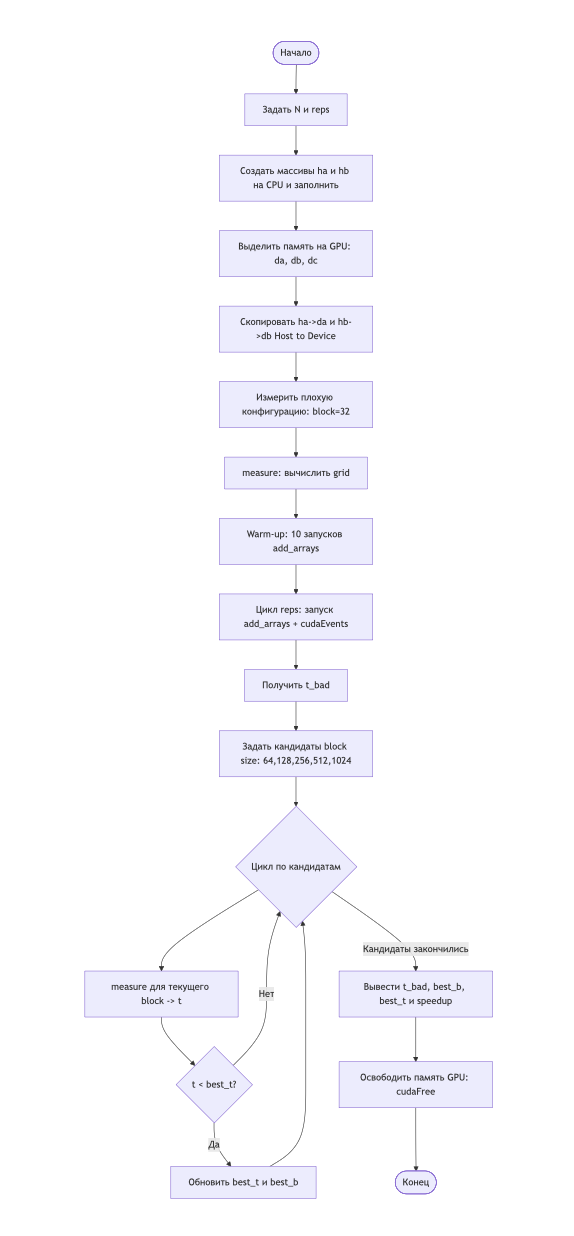

In [ ]:
%%writefile task4_optimize_config.cu
#include <cstdio>              // для printf
#include <vector>              // для std::vector (массивы на CPU)
#include <cuda_runtime.h>      // CUDA функции (cudaMalloc, cudaMemcpy, events и т.д.)

// Макрос для проверки ошибок CUDA (если ошибка — печатаем и выходим)
#define CHECK(call) do{ cudaError_t e=(call); if(e!=cudaSuccess){ \
  printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); exit(1);} }while(0)

// ---------------------
// CUDA kernel: поэлементное сложение массивов
// c[i] = a[i] + b[i]
__global__ void add_arrays(const float* __restrict__ a,   // входной массив A в global memory
                           const float* __restrict__ b,   // входной массив B в global memory
                           float* __restrict__ c,         // выходной массив C в global memory
                           int n){                        // размер массива
  int i = blockIdx.x * blockDim.x + threadIdx.x;          // глобальный индекс элемента
  if(i < n) c[i] = a[i] + b[i];                           // если индекс в пределах, складываем
}

// ---------------------
// Функция measure: измеряет среднее время одного запуска kernel для конкретного block size
float measure(const float* a, const float* b, float* c,    // указатели на GPU массивы
              int n,                                       // размер массива
              int block,                                   // размер блока потоков (block size)
              int reps){                                   // количество повторов kernel
  int grid = (n + block - 1) / block;                     // считаем количество блоков (grid size)

  cudaEvent_t st, en;                                      // CUDA events для измерения времени
  CHECK(cudaEventCreate(&st));                             // создаём start event
  CHECK(cudaEventCreate(&en));                             // создаём end event

  // warm-up: прогрев GPU, чтобы первый запуск не искажал время
  for(int i=0;i<10;i++) add_arrays<<<grid,block>>>(a,b,c,n); // несколько запусков kernel
  CHECK(cudaDeviceSynchronize());                          // ждём завершения прогрева

  CHECK(cudaEventRecord(st));                              // старт измерения времени
  for(int i=0;i<reps;i++) add_arrays<<<grid,block>>>(a,b,c,n); // запускаем kernel reps раз
  CHECK(cudaEventRecord(en));                              // конец измерения времени
  CHECK(cudaEventSynchronize(en));                         // ждём пока события точно завершатся

  float ms = 0;                                            // переменная для времени
  CHECK(cudaEventElapsedTime(&ms, st, en));                // считаем время между st и en (в ms)

  CHECK(cudaEventDestroy(st));                             // удаляем start event
  CHECK(cudaEventDestroy(en));                             // удаляем end event

  return ms / reps;                                        // возвращаем среднее время одного запуска
}

int main(){
  const int N = 1'000'000;                                 // размер массивов
  const size_t bytes = (size_t)N * sizeof(float);          // размер памяти в байтах

  // создаём два массива на CPU
  std::vector<float> ha(N), hb(N);                         // A и B на CPU
  for(int i=0;i<N;i++){                                    // заполняем простыми значениями
    ha[i] = (i%100) * 0.01f;
    hb[i] = (i%50)  * 0.02f;
  }

  // указатели на GPU массивы
  float *da=nullptr, *db=nullptr, *dc=nullptr;             // da=A, db=B, dc=C

  CHECK(cudaMalloc(&da, bytes));                           // выделяем память на GPU под A
  CHECK(cudaMalloc(&db, bytes));                           // выделяем память на GPU под B
  CHECK(cudaMalloc(&dc, bytes));                           // выделяем память на GPU под C

  CHECK(cudaMemcpy(da, ha.data(), bytes, cudaMemcpyHostToDevice)); // копируем A: CPU -> GPU
  CHECK(cudaMemcpy(db, hb.data(), bytes, cudaMemcpyHostToDevice)); // копируем B: CPU -> GPU

  const int reps = 20000;                                  // количество повторов для стабильного замера

  // "плохая" конфигурация: маленький block size
  int bad_block = 32;                                      // один варп, обычно не оптимально
  float t_bad = measure(da, db, dc, N, bad_block, reps);    // измеряем среднее время для плохого варианта

  // кандидаты block size, которые тестируем
  int cand[] = {64, 128, 256, 512, 1024};                  // возможные размеры блока
  float best_t = 1e9f;                                     // большое число как начальное лучшее время
  int best_b = -1;                                         // лучший block size

  // перебираем кандидаты и ищем самый быстрый
  for(int i=0;i<5;i++){
    float t = measure(da, db, dc, N, cand[i], reps);        // измеряем среднее время для текущего блока
    if(t < best_t){                                        // если нашли вариант быстрее
      best_t = t;                                          // обновляем лучшее время
      best_b = cand[i];                                    // запоминаем лучший block size
    }
  }

  // выводим результаты измерений
  printf("Task 4 (N=%d, reps=%d)\n", N, reps);              // заголовок
  printf("  bad config   : block=%d  avg=%.6f ms\n", bad_block, t_bad); // плохая конфигурация
  printf("  best config  : block=%d  avg=%.6f ms\n", best_b, best_t);   // лучшая конфигурация
  printf("  speedup      : %.2fx\n", t_bad / best_t);       // ускорение = плохое / лучшее

  // освобождаем память GPU
  CHECK(cudaFree(da));                                     // освобождаем A
  CHECK(cudaFree(db));                                     // освобождаем B
  CHECK(cudaFree(dc));                                     // освобождаем C

  return 0;                                                 // конец программы
}

Overwriting task4_optimize_config.cu


In [ ]:
!nvcc -O3 -arch=sm_75 task4_optimize_config.cu -o task4
!./task4

Task 4 (N=1000000, reps=20000)
  bad config   : block=32  avg=0.059422 ms
  best config  : block=256  avg=0.048484 ms
  speedup      : 1.23x


Вывод: В качестве неоптимальной конфигурации выбран block = 32, а по результатам перебора (64/128/256/512/1024) оптимальной оказалась block = 256. Среднее время выполнения уменьшилось с 0.059422 ms до 0.048484 ms, что соответствует ускорению примерно 1.23×. Это связано с тем, что при block=256 GPU лучше загружается (больше активных варпов), и задержки доступа к памяти скрываются эффективнее.

# Контрольные вопросы к Assignment 3
1. Какие основные типы памяти существуют в архитектуре CUDA и чем они
отличаются по скорости доступа?

Есть регистры (самые быстрые), shared memory (быстрая внутри блока), global memory (самая медленная, но большая), ещё есть constant/texture (глобальная, но кэшируется) и local (в глобальной, если не хватает регистров).

2. В каких случаях использование разделяемой памяти позволяет ускорить
выполнение CUDA-программы?

Когда потоки блока используют одни и те же данные несколько раз (например, матрицы, редукция). Тогда меньше чтений из global → быстрее.

3. Как шаблон доступа к глобальной памяти влияет на производительность GPU-
программы?

Если потоки читают рядом (coalesced) — быстро. Если “скачками” (non-coalesced) — много лишних обращений → медленно.

4. Почему одинаковый алгоритм на GPU может показывать разное время выполнения
при разных способах обращения к памяти?

Потому что время часто зависит от памяти, а не от вычислений. Если доступ к памяти другой (не коалесцированный/лишние обращения), будет другое время.

5. Как размер блока потоков влияет на производительность CUDA-ядра?

Меняет количество активных потоков/варпов (occupancy). Маленький блок — мало параллелизма, слишком большой — может упереться в регистры/shared.

6. Что такое варп и почему важно учитывать его при разработке CUDA-программ?

Варп — это 32 потока, которые выполняются вместе. Если внутри варпа есть разные ветки (if/else), часть потоков простаивает (divergence).

7. Какие факторы необходимо учитывать при выборе конфигурации сетки и блоков
потоков?

Размер данных, ограничения GPU, shared/регистры, occupancy, и лучше всего — просто замерить время для разных block sizes.

8. Почему оптимизация CUDA-программы часто начинается с анализа работы с
памятью, а не с изменения алгоритма?

Потому что GPU часто “тормозит” из-за медленного доступа к global memory. Если правильно работать с памятью, ускорение можно получить без изменения алгоритма.